<a href="https://colab.research.google.com/github/AlirezaAK2000/Adad_khon/blob/master/AI_First_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# A function to plot images
def show_image(img):
    image = img.reshape((28, 28))
    plt.imshow(image, 'gray')
def right_shift(xs, num_shift):
  for i in range(num_shift):
    xs = np.c_[xs[:,-1],xs[:,:-1]]
  return xs
def read_data():
  train_images_file = open('drive/MyDrive/colab samples/train-images.idx3-ubyte', 'rb')
  train_images_file.seek(4)
  num_of_train_images = int.from_bytes(train_images_file.read(4), 'big')
  train_images_file.seek(16)

  train_labels_file = open('drive/MyDrive/colab samples/train-labels.idx1-ubyte', 'rb')
  train_labels_file.seek(8)

  train_set = []
  for n in range(num_of_train_images):
    image = np.zeros((784, 1))
    for i in range(784):
        image[i, 0] = int.from_bytes(train_images_file.read(1), 'big') / 256
    
    label_value = int.from_bytes(train_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
      
    train_set.append((image, label))
  # Reading The Test Set
  test_images_file = open('drive/MyDrive/colab samples/t10k-images.idx3-ubyte', 'rb')
  test_images_file.seek(4)

  test_labels_file = open('drive/MyDrive/colab samples/t10k-labels.idx1-ubyte', 'rb')
  test_labels_file.seek(8)

  num_of_test_images = int.from_bytes(test_images_file.read(4), 'big')
  test_images_file.seek(16)

  shifted_test_set = []
  test_set = []
  for n in range(num_of_test_images):
    image = np.zeros((784, 1))
    image_mat = np.zeros((28,28))
    for i in range(784):
        data = int.from_bytes(test_images_file.read(1), 'big') / 256
        image[i] = data
        image_mat[i // 28][i % 28] = data

    
    # corrupting data for adverserial attack
    image_mat = right_shift(image_mat , 4).flatten().reshape(-1,1)
    assert(image.shape == image_mat.shape)

    shifted_test_set.append(image_mat)

    label_value = int.from_bytes(test_labels_file.read(1), 'big')
    label = np.zeros((10, 1))
    label[label_value, 0] = 1
    
    test_set.append((image, label))

  train_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in train_set])))
  test_set_x_v = np.transpose(np.squeeze(np.array([rec[0] for rec in test_set])))

  train_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in train_set])))
  test_set_y_v = np.transpose(np.squeeze(np.array([rec[1] for rec in test_set])))

  shifted_test_set_x_v = np.transpose(np.squeeze(np.array(shifted_test_set)))

  assert(shifted_test_set_x_v.shape == test_set_x_v.shape)

  return train_set_x_v , test_set_x_v , train_set_y_v , test_set_y_v , shifted_test_set_x_v

<div dir=rtl>
در همان ابتدای کار نمونه های test
و train
را به صورت vectorize 
در می آوریم و یک کپی از داده های test را 
۴ بار به سمت 
راست شیفت می‌دهیم.
</div>

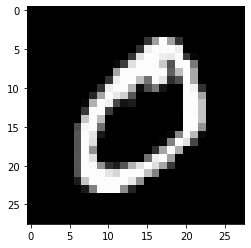


shifted pic :



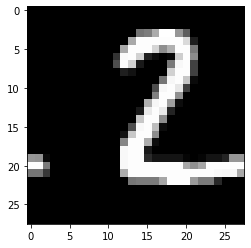

In [5]:
train_set_x_v , test_set_x_v , train_set_y_v , test_set_y_v , shifted_test_set_x_v= read_data()
show_image(np.transpose(train_set_x_v[:,1]))
plt.show()
# corrupted
print('\nshifted pic :\n')
show_image(np.transpose(shifted_test_set_x_v[:,1]))
plt.show()

In [6]:
def sigmoid(A):
  return 1/(1+np.exp(-1 * A))
def sigmoid_deriv(A):
  sig = sigmoid(A)
  return sig * (1 - sig)
def softmax(A):
  e = np.exp(A)
  return e / np.sum(e)
def relu(A):
  return np.maximum(A , 0)
def relu_deriv(A):
  return (A > 0).astype(int)
def tanh(A):
  return np.tanh(A)
def tanh_deriv(A):
  return 1 - tanh(A) ** 2
def leaky_relu(A,alpha=0.01):
  return np.where(A > 0, A, A * alpha)     
def leaky_relu_deriv(A, alpha=0.01):
  dx = np.ones_like(A)
  dx[A < 0] = alpha
  return dx                     

<div dir =rtl>
<h1><b>
مدل شبکه عصبی
</b></h1>

مدل خود را می توانید به صورت زیر تعریف کنید به این صورت که خط اول تعداد نورون های لایه ورودی و در خطوط بعدی تعداد نورون ها،تابع فعال سازی و مشتق آن را میدهیم.

```
(dataset_size , None)
```



```
(neurons , activation , activation_deriv)
```
مدل خواسته شده در پروژه به صورت زیر است:

</div>

In [7]:
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
model

[(784, None),
 (16, <function __main__.relu>, <function __main__.relu_deriv>),
 (16, <function __main__.relu>, <function __main__.relu_deriv>),
 (10, <function __main__.sigmoid>, <function __main__.sigmoid_deriv>)]

In [10]:
np.random.seed(2)
def get_dimensions(model):
  dimensions = [(model[i+1][0], model[i][0]) for i in range(len(model)-1)]
  return dimensions

<div dir=rtl><h1><b>
مقدار دهی وزن ها
</b></h1></div>
<div dir=rtl>
استفاده از تکنیک مناسب برای مقداردهی اولیه به یادگیری سریع تر و بهتر شبکه عصبی کمک میکند.اگر تمام وزن هارا صفر بدهیم یا اینکه مقادیر بسیار کوچک باشد آنگاه باعث می شود که cost  تغییری نکند.
در اینجا از یک متد مقداردهی به نام 
<b>HE</b>
استفاده می‌کنیم:
<a href=https://arxiv.org/abs/1512.03385>
[He et al., 2015]
</a>
<br>
تابع بعدی نیز برای مقداردهی وزن های 
<b>
Momentum
</b>
است که به همه وزن ها مقادیر صفر می‌دهد.
</div>

In [11]:
def initializer(shape ):
  w = np.random.randn(shape[0],shape[1]) * np.sqrt(2./shape[1])
  # b = np.random.randn(shape[0] , 1) * np.sqrt(2./shape[1])
  b = np.zeros((shape[0] , 1))

  return (w , b)
def V_initializer(shape ):
  v_w = np.zeros(shape)
  v_b = np.zeros((shape[0] , 1))

  return (v_w , v_b)

In [13]:
def initialize(model,use_momentum = False):
  W = []
  B = []
  dimensions = get_dimensions(model)
  for shape in dimensions:
    w , b  = initializer(shape)
    assert(w.shape == shape)
    assert(b.shape == (shape[0] , 1))
    W.append(w)
    B.append(b)
  if use_momentum:
    V = {'dW':[],'dB':[]}
    for shape in dimensions:
      v_w , v_b  = V_initializer(shape)
      V['dW'].append(v_w)
      V['dB'].append(v_b)
    return W , B , V

  return W , B , None

In [14]:
def mse_cost(y , y_prim):
  return np.sum((y_prim-y)**2)/y.shape[1]

<div dir=rtl>
کد مربوط به پیاده‌سازی 
<b>Forward Propagation</b>
در تابع زیر آمده است.
در آخر 
<b>
Activation
</b>
 های هر لایه را برای 
<b>
Forward Propagation
</b>
، 
ذخیره می‌کنیم.
</div>

In [15]:
def forward_propagation(X , W , B,model):
  layers_num = len(W)
  A = [X]
  Z = []
  for i in range(layers_num):
    # assert(W[i].shape[1] == X.shape[0])
    z = W[i] @ A[i] + B[i]
    a = model[i + 1][1](z)
    A.append(a)
    Z.append(z)
    # print(z.shape)
  return {
      'A':A,
      'Z':Z
  }

<div dir=rtl>
در تابع زیر نیز 
<b>
Forward Propagration
</b>
پیاده سازی شده است و در آخر گرادیان‌ها را به ما برمی‌گرداند.

In [18]:
def backward_propagation(W , B , cache, Y , model):
  A , Z = cache['A'] ,cache['Z']
  # print(Z)
  dW , dB= [] , []
  layers_num = len(W)
  tmp = (2 * (A[-1] - Y)) * model[-1][2](Z[-1])
  db = tmp  @ np.ones((A[-1].shape[1],1))
  dw = tmp  @ np.transpose(A[-2])
  dA = [np.transpose(W[-1]) @ tmp]
  assert(dw.shape == W[-1].shape)
  assert(db.shape == B[-1].shape)
  dW.append(dw)
  dB.append(db)
  for i in reversed(range(layers_num - 1)):
    tmp = dA[0] * model[i+1][2](Z[i])
    db = tmp @ np.ones((tmp.shape[1],1))
    dw = tmp @ np.transpose(A[i])
    da = np.transpose(W[i]) @ tmp
    dA.insert(0,da)
    dW.insert(0,dw)
    dB.insert(0,db)
    assert(dw.shape == W[i].shape)
    assert(db.shape == B[i].shape)

  return {
      'dW':dW,
      'dB':dB
  }
    
def predict(W, B , X , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  return np.where(Y_prim.reshape(Y_prim.shape[1]) == 1)[0][0]



<div dir=rtl> 
در آخر نیز فرایند یادگیری در تابع 
<b>
main_model
</b>
انجام می‌شود.
به عنوان خروجی نیز وزن ها و دقت شبکه عصبی بر روی داده های 
Test 
و
Train 
داده می‌شود.
همانطور که می‌دانیم 
<b>
Cost
</b>
در روش
<b>
SGD
</b>
نوسانات زیادی دارد و برای از بین بردن این نوسانات معمولا از تکنیک های مختلفی مانند: 


1.   Momentum
2.   RMSprop
3.   ADAM

استفاده می‌شود که در اینجا ما از 
<b>Momentum</b>
استفاده کرده‌ایم.
ایده اصلی استفاده از مفهومی به نام 
<b>
Exponential Average 
</b>
است.
همانطور که قبلا دیدیم مقدارهی اولیه این وزن ها در خطوط بالا انجام شده است و در اینجا ما در خطوط ۲۸ تا ۳۱ به پیاده‌سازی این روش پرداخته‌ایم.
درادامه نیز به تاثیر این پیاده‌سازی بر نوسانات 
<b>
Cost
</b>
می‌پردازیم.

</div>

In [20]:
from collections import defaultdict
def test(W, B , X ,Y , model):
  cache = forward_propagation(X , W , B , model)
  Y_prim = cache['A'][-1]
  Y_prim = np.round(Y_prim)
  result = defaultdict(lambda : 0,dict(zip(*(np.unique((Y_prim == Y).all(0) , return_counts=True)))))
  return result[True] / (result[True] + result[False]) * 100


def main_model(model , X , Y ,X_test , Y_test , epoch=200 , batch_size=20 , a=1, use_momentum = False, beta=0.9):
  costs , test_accuracies , train_accuracies = [] , [] , []
  num_iteration = X.shape[1]//batch_size
  W , B , V = initialize(model,use_momentum)
  for i in range(epoch):
    cost = None
    for j in range(num_iteration):
      batch_x = X[:,j*batch_size:(j+1)*batch_size]
      batch_y = Y[:,j*batch_size:(j+1)*batch_size]
      cache = forward_propagation(batch_x , W,B,model)
      cost = mse_cost(batch_y , cache['A'][-1])
      gradients = backward_propagation(W , B , cache , batch_y , model)
      if not use_momentum:
        for k in range(len(W)):
          W[k] = W[k] - a * gradients['dW'][k]
          B[k] = B[k] - a * gradients['dB'][k]
      else:
        for k in range(len(W)):
          V['dW'][k] = beta * V['dW'][k] + (1 - beta) * gradients['dW'][k]
          W[k] = W[k] - a * V['dW'][k]
          V['dB'][k] = beta * V['dB'][k] + (1 - beta) * gradients['dB'][k]
          B[k] = B[k] - a * V['dB'][k]
    # if i % 10 == 0:
    train_accuracy = test(W , B , X , Y , model)
    test_accuracy = test(W , B , X_test , Y_test , model)
    print(f'*** epoch : {i} ======> cost : {cost} , train accuracy : {train_accuracy} , test accuracy : {test_accuracy}')
    costs.append(cost)
    test_accuracies.append(test_accuracy)
    train_accuracies.append(train_accuracy)

  train_accuracy = test(W , B , X , Y , model)
  test_accuracy = test(W , B , X_test , Y_test , model)
  print('__________________________________________________')
  print(f"train accuracy: {train_accuracy}")
  print(f"test accuracy: {test_accuracy}")  
  return costs , test_accuracies , train_accuracies , W , B



In [21]:
def plot_result(info): 
  plt.plot([i for i in range(1,len(info[0])+1)] , info[0] , label='cost')
  plt.legend(loc="upper right", frameon=False)
  plt.show()
  plt.plot([i for i in range(1,len(info[1])+1)] , info[1] , label='test accuracy')
  plt.plot([i for i in range(1,len(info[2])+1)] , info[2] , label='train accuracy')
  plt.legend(loc="upper left", frameon=False)
  plt.show()

def describe_model(model):
  print('\n'.join([str({'activation units':model[i][0],'activation function':model[i][1].__name__ ,'parameters': model[i][0]*model[i-1][0] }) if model[i][1] else f'input layer : {model[i][0]}' for i in range(len(model))]))


<div dir=rtl>
در شبکه زیر به عنوان ورودی ۱۰۰ داده اول را داده‌ایم و همانطور که از خروجی دیده می‌شود دقت بسیار پایین است با این که دقت فقط برروی همان داده های 
<b>
Train
</b>
اندازه‌گیری شده‌است.
بااین حال همانطور که توقع داشتیم هزینه روندی نزولی داشته‌است.
<div>

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.9353647483291379 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 1 ======> cost : 0.9285564843508258 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 2 ======> cost : 0.9153415958714491 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 3 ======> cost : 0.9029976841170276 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 4 ======> cost : 0.8943575115242766 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 5 ======> cost : 0.8871290007203287 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 6 ======> cost : 0.8802977435610263 , train accuracy : 0.0 , test accuracy : 0.0
*** epoch : 7 ======> cost : 0.8725994611887371 , train accuracy : 0.0 , test accuracy : 0.0
**

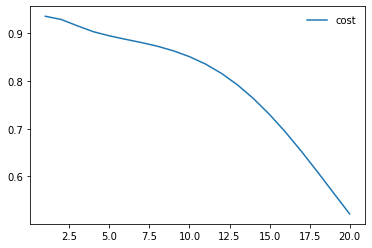

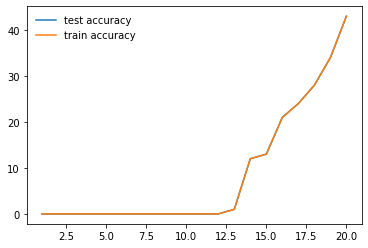

In [44]:
# using sigmoid without momentum
# learning on first 100 samples
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v[:,:100], train_set_y_v[:,:100],train_set_x_v[:,:100], train_set_y_v[:,:100],a=0.1, epoch=20 )
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

<div dir=rtl>
در ادامه به آزمایش تاثیر استفاده از 
<b>
Momentum
</b>
در کنار توابع فعالسازی مختلف می‌پردازیم.
همانطور که در نتایج دیده می‌شود این تکنیک توانسته تا حد خوبی این نوسانات را کنترل کند.
عملکرد این روش به مقداری که برای پارامتر 
<b><i>
beta
</i></b>
ست می‌کنیم دارد.
این مقدار معمولا روی 0.9 ست می‌شود.
</div>

input layer : 784
{'activation units': 16, 'activation function': 'relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.05683344175404874 , train accuracy : 84.44333333333334 , test accuracy : 84.55
*** epoch : 1 ======> cost : 0.004813840609163047 , train accuracy : 87.29166666666667 , test accuracy : 86.99
*** epoch : 2 ======> cost : 0.003366621126146703 , train accuracy : 87.75666666666667 , test accuracy : 87.74
*** epoch : 3 ======> cost : 0.0008431110888929814 , train accuracy : 88.765 , test accuracy : 88.85
*** epoch : 4 ======> cost : 0.00155396746824631 , train accuracy : 89.275 , test accuracy : 88.88000000000001
*** epoch : 5 ======> cost : 0.0003466200122428818 , train accuracy : 89.37 , test accuracy : 89.03
*** epoch : 6 ======> cost : 0.0010370478622880731 , train accuracy : 90.31833333333333 , test accuracy : 89

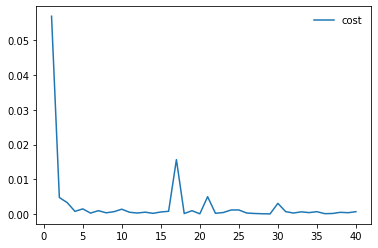

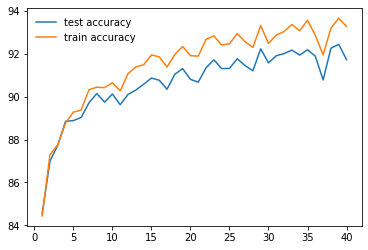

In [66]:
# using relu and momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.9)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.10161006206631165 , train accuracy : 78.25166666666667 , test accuracy : 78.10000000000001
*** epoch : 1 ======> cost : 0.10137221485600582 , train accuracy : 79.965 , test accuracy : 79.97
*** epoch : 2 ======> cost : 0.1394841521370324 , train accuracy : 80.78999999999999 , test accuracy : 80.78999999999999
*** epoch : 3 ======> cost : 0.14877480694329184 , train accuracy : 82.81500000000001 , test accuracy : 82.71
*** epoch : 4 ======> cost : 0.12694508378105684 , train accuracy : 82.77333333333333 , test accuracy : 82.69
*** epoch : 5 ======> cost : 0.1160718011453997 , train accuracy : 83.565 , test accuracy : 83.47
*** epoch : 6 ======> cost : 0.10587546102737659 , train accuracy : 83.87 , test accuracy : 

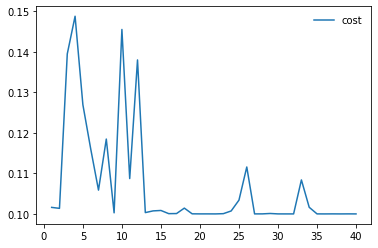

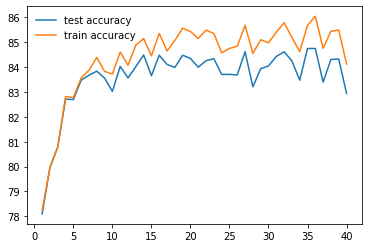

In [67]:
# using relu and without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , relu ,relu_deriv ),
    (16 , relu ,relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=False)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.22680323921975284 , train accuracy : 73.205 , test accuracy : 74.33
*** epoch : 1 ======> cost : 0.06362146726019205 , train accuracy : 85.22333333333333 , test accuracy : 85.53
*** epoch : 2 ======> cost : 0.03416333655926474 , train accuracy : 87.47333333333333 , test accuracy : 87.7
*** epoch : 3 ======> cost : 0.021534653049827428 , train accuracy : 88.65666666666667 , test accuracy : 89.0
*** epoch : 4 ======> cost : 0.017474946464590153 , train accuracy : 89.38166666666667 , test accuracy : 89.64999999999999
*** epoch : 5 ======> cost : 0.016941855941534655 , train accuracy : 89.96 , test accuracy : 90.08
*** epoch : 6 ======> cost : 0.018310641067381995 , train accuracy : 90.45666666666666 , test ac

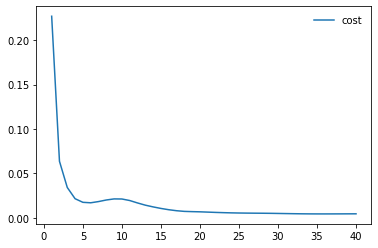

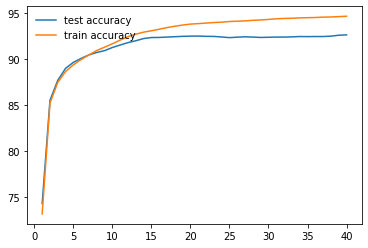

In [47]:
# using sigmoid with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.9)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.21405427485599365 , train accuracy : 70.40833333333333 , test accuracy : 71.05
*** epoch : 1 ======> cost : 0.045454383903222775 , train accuracy : 84.84166666666667 , test accuracy : 84.96000000000001
*** epoch : 2 ======> cost : 0.021988947361763662 , train accuracy : 87.355 , test accuracy : 87.52
*** epoch : 3 ======> cost : 0.015891156006671275 , train accuracy : 88.6 , test accuracy : 88.64999999999999
*** epoch : 4 ======> cost : 0.013606488160372738 , train accuracy : 89.42833333333333 , test accuracy : 89.42
*** epoch : 5 ======> cost : 0.013245056447849115 , train accuracy : 90.05666666666666 , test accuracy : 89.89
*** epoch : 6 ======> cost : 0.013541606894351483 , train accuracy : 90.649999999

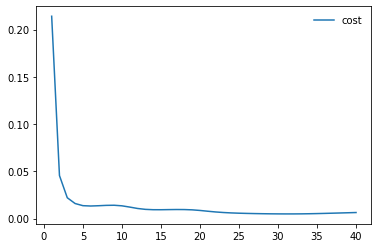

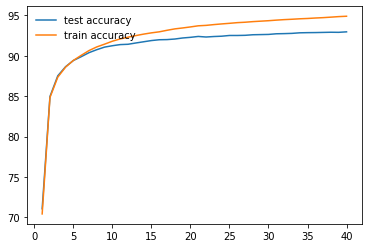

In [48]:
# using sigmoid without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 )
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'tanh', 'parameters': 12544}
{'activation units': 16, 'activation function': 'tanh', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.009912547609995775 , train accuracy : 87.29666666666667 , test accuracy : 87.17
*** epoch : 1 ======> cost : 0.00492074478227055 , train accuracy : 90.795 , test accuracy : 90.48
*** epoch : 2 ======> cost : 0.012192932578503077 , train accuracy : 91.33 , test accuracy : 90.8
*** epoch : 3 ======> cost : 0.002937287738472487 , train accuracy : 92.37666666666667 , test accuracy : 91.71000000000001
*** epoch : 4 ======> cost : 0.006697127965472792 , train accuracy : 92.35333333333332 , test accuracy : 91.53999999999999
*** epoch : 5 ======> cost : 0.004971741033102149 , train accuracy : 92.14666666666666 , test accuracy : 91.43
*** epoch : 6 ======> cost : 0.01141769369962594 , train accuracy : 92.92166666666667 ,

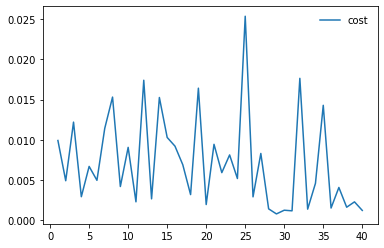

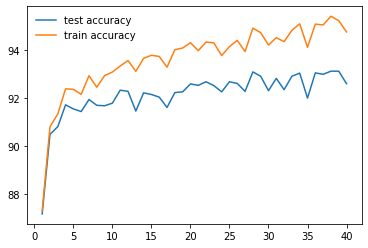

In [49]:
# using tanh with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , tanh ,tanh_deriv ),
    (16 , tanh ,tanh_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40, use_momentum=True , beta=0.9)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'tanh', 'parameters': 12544}
{'activation units': 16, 'activation function': 'tanh', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.020956825564612494 , train accuracy : 87.98166666666667 , test accuracy : 88.24
*** epoch : 1 ======> cost : 0.022359216499997926 , train accuracy : 90.77 , test accuracy : 90.98
*** epoch : 2 ======> cost : 0.010109170441944763 , train accuracy : 91.55 , test accuracy : 91.12
*** epoch : 3 ======> cost : 0.008530342331046683 , train accuracy : 91.97999999999999 , test accuracy : 91.4
*** epoch : 4 ======> cost : 0.006612732499632063 , train accuracy : 92.44 , test accuracy : 91.75999999999999
*** epoch : 5 ======> cost : 0.0037913262888858664 , train accuracy : 92.825 , test accuracy : 92.0
*** epoch : 6 ======> cost : 0.002386791500049685 , train accuracy : 93.17333333333333 , test accuracy : 92.22
*** epoch :

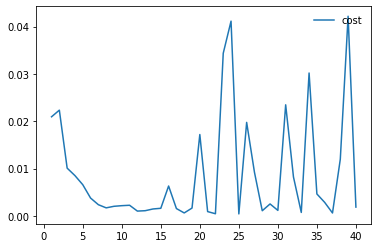

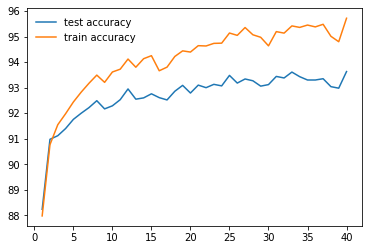

In [50]:
# using tanh without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , tanh ,tanh_deriv ),
    (16 , tanh ,tanh_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40, use_momentum=False )
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.2070398780154962 , train accuracy : 77.84 , test accuracy : 78.33
*** epoch : 1 ======> cost : 0.21606485943987513 , train accuracy : 80.12166666666667 , test accuracy : 79.92
*** epoch : 2 ======> cost : 0.16387137193308315 , train accuracy : 80.24 , test accuracy : 79.63
*** epoch : 3 ======> cost : 0.15097282987912028 , train accuracy : 79.73166666666667 , test accuracy : 79.25999999999999
*** epoch : 4 ======> cost : 0.15104516739417279 , train accuracy : 81.70666666666668 , test accuracy : 80.89
*** epoch : 5 ======> cost : 0.1561051496732332 , train accuracy : 82.16833333333334 , test accuracy : 81.71000000000001
*** epoch : 6 ======> cost : 0.16407151373689982 , train accuracy : 82.49333333333

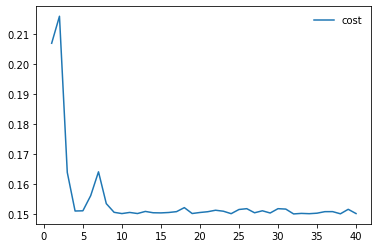

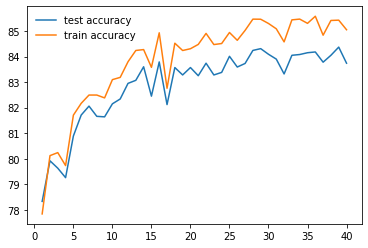

In [51]:
# using leaky relu with momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=True , beta=0.9)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

input layer : 784
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 12544}
{'activation units': 16, 'activation function': 'leaky_relu', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.12324627142729938 , train accuracy : 79.00166666666667 , test accuracy : 79.12
*** epoch : 1 ======> cost : 0.1032576255477911 , train accuracy : 81.11 , test accuracy : 80.75
*** epoch : 2 ======> cost : 0.1102808488903492 , train accuracy : 81.91833333333334 , test accuracy : 81.5
*** epoch : 3 ======> cost : 0.10428959874911918 , train accuracy : 82.905 , test accuracy : 82.35
*** epoch : 4 ======> cost : 0.14259500343925344 , train accuracy : 81.03666666666666 , test accuracy : 80.84
*** epoch : 5 ======> cost : 0.13315294813098064 , train accuracy : 83.06833333333333 , test accuracy : 82.66
*** epoch : 6 ======> cost : 0.13220408436423706 , train accuracy : 82.83333333333334 , test accuracy : 82

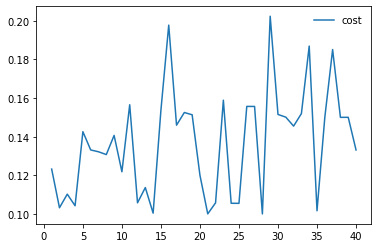

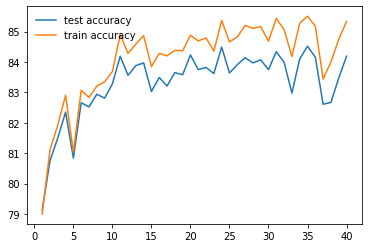

In [52]:
# using leaky relu without momentum
model = [
    (train_set_x_v.shape[0] , None),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (16 , leaky_relu ,leaky_relu_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=40 , use_momentum=False)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

<div dir=rtl>
<h1><b>Adverserial Attack</h1></b>
در این نوع حمله معمولا به داده های یک نویز وارد می‌شود.برای مثال به داده های تصویری معمولا به پیکسل های آنها مقادیری تصادفی اعمال می‌شود با این 
<b>
shift
</b>
پیدا می‌کنند یا روش های دیگر.
در اینجا داده های 
<b>
Test
</b>
را به اندازه ۴ واحد به سمت راست 
<b>shift</b>
دادیم.
نتیجه آن تغییر زیاد بین دقت شبکه عصبی روی 
<b>
Test Set
</b>
و
<b>
Train Set
</b>
است که از نشانه‌های
<b>
Overfit
</b>
است.
دلیل آن تازه بودن داده‌های 
<b>Test</b>
برای شبکه عصبی است.
درواقع داده‌های 
<b>Test</b>
,
<b>Train</b>
باید از یک توزیع
(
  <b>distribution</b>
)
باشند تا از این مشکل جلوگیری شود.
</div>

input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.20928117310148978 , train accuracy : 72.72333333333333 , test accuracy : 12.09
*** epoch : 1 ======> cost : 0.06632370355159434 , train accuracy : 84.245 , test accuracy : 15.25
*** epoch : 2 ======> cost : 0.03984728456312951 , train accuracy : 86.99333333333334 , test accuracy : 17.49
*** epoch : 3 ======> cost : 0.026390704529991836 , train accuracy : 88.53999999999999 , test accuracy : 19.09
*** epoch : 4 ======> cost : 0.021030510273611164 , train accuracy : 89.48833333333333 , test accuracy : 19.89
*** epoch : 5 ======> cost : 0.018327701080707248 , train accuracy : 90.10666666666667 , test accuracy : 20.51
*** epoch : 6 ======> cost : 0.016248695033599186 , train accuracy : 90.655 , test accuracy : 

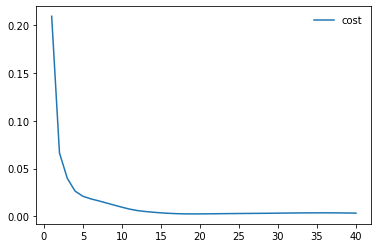

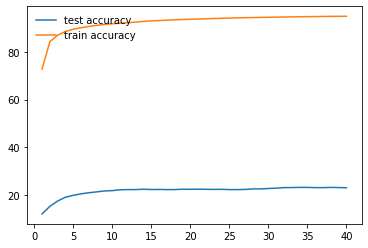

In [55]:
# testing corrupted dataset
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,shifted_test_set_x_v , test_set_y_v,a=0.01, epoch=40)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

<div dir=rtl>
در آخر نیز شبکه عصبی خود را با تعداد 
<b>Epoch</b>
بیشتر تعلیم می‌دهیم.
بیشترین دقت های دیده شده برروی هر دو مجموعه داده به شرح زیر است:

</div>

*   Test Set : 94
*   Train Set : 97


input layer : 784
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 12544}
{'activation units': 16, 'activation function': 'sigmoid', 'parameters': 256}
{'activation units': 10, 'activation function': 'sigmoid', 'parameters': 160}
*** epoch : 0 ======> cost : 0.40848440515107676 , train accuracy : 57.14 , test accuracy : 58.440000000000005
*** epoch : 1 ======> cost : 0.16463396076379813 , train accuracy : 84.28166666666667 , test accuracy : 84.58
*** epoch : 2 ======> cost : 0.12006005115486983 , train accuracy : 87.66333333333334 , test accuracy : 87.76
*** epoch : 3 ======> cost : 0.09730532293288417 , train accuracy : 89.21833333333333 , test accuracy : 88.9
*** epoch : 4 ======> cost : 0.07928239193774593 , train accuracy : 90.11 , test accuracy : 89.48
*** epoch : 5 ======> cost : 0.06691411425663125 , train accuracy : 90.725 , test accuracy : 90.06
*** epoch : 6 ======> cost : 0.0592397472187328 , train accuracy : 91.20666666666666 , test accuracy : 90.52


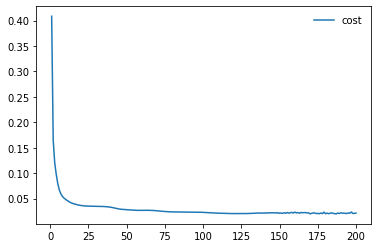

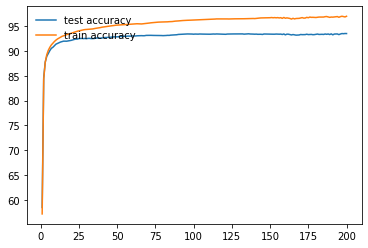

In [65]:
# final result
model = [
    (train_set_x_v.shape[0] , None),
    (16 , sigmoid ,sigmoid_deriv ),
    (16 , sigmoid ,sigmoid_deriv ),
    (10 , sigmoid , sigmoid_deriv),
]
describe_model(model)
start = time.time()
info = main_model(model , train_set_x_v, train_set_y_v,test_set_x_v , test_set_y_v,a=0.01, epoch=200 , use_momentum=True , beta=0.85 , batch_size=120)
finish = round(time.time() - start , 3)
print('min {} : sec {}'.format(finish//60 , finish % 60))
plot_result(info)

<div dir=rtl>
مدل خود را بر روی یکی از تصاویر امتحان می‌کنیم!!!
</div>

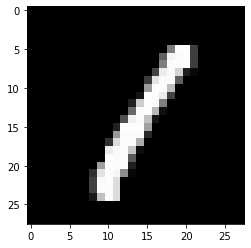

predicted value: 1


In [60]:
show_image(np.transpose(train_set_x_v[:,3]))
pic = train_set_x_v[:,3].reshape((1,-1,1))
W , B = info[3], info[4]
plt.show()
print(f"predicted value: {predict(W,B,pic, model )}")

